# <b>Assignment : DT</b>

<font color='red'><b> Please check below video before attempting this assignment</b></font>

## Importing Libraries

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1.1 Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignments/11.Assignment/preprocessed_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Creating some list to store th data from SentimentIntensityAnalyzer
negative = []
positive = []
neutral = []
compound = []
def update_sentiments(values):
 negative.append(values["neg"])
 positive.append(values["pos"])
 neutral.append(values["neu"])
 compound.append(values["compound"])

In [ ]:
from tqdm import tqdm
sid = SentimentIntensityAnalyzer()
for essay in tqdm(data["essay"]):
 update_sentiments(sid.polarity_scores(essay))

100%|██████████| 109248/109248 [04:09<00:00, 438.01it/s]


In [ ]:
# adding new features to dataset based on Sentiment Intensity Analyzer
data["neg"] = negative
data["pos"] = positive
data["neu"] = neutral 
data["compound"] = compound

Splitting Data Into Train and  test: Stratified Sampling

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

In [ ]:
print("Total data points in Train Dataset =",len(y_train))
print("Total data points in Test Dataset =",len(y_test))

Total data points in Train Dataset = 73196
Total data points in Test Dataset = 36052


## Make Data Model Ready: Encoding Eassay(text feature)

TFIDF Vectorizer

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidfvectorizer.fit(X_train['essay'].values) #fitting
X_train_essay_tfidf =tfidfvectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf =tfidfvectorizer.transform(X_test['essay'].values) # transform
print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


TFIDF W2V


In [ ]:
import pickle
with open (r'/content/drive/MyDrive/Colab Notebooks/Assignments/11.Assignment/glove_vectors', "rb") as f:
 model = pickle.load(f)
 glove_words = set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["essay"]) # we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
#TFIDF W2V for train dataset
from tqdm import tqdm
import numpy as np
X_train_tfidf_w2v = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_train["essay"]):
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
           vector += model[word]
           tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
           tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
       vector /= tf_idf_weight
    X_train_tfidf_w2v.append(vector)
X_train_tfidf_w2v=np.array(X_train_tfidf_w2v)
print("After vectorizations")
print(X_train_tfidf_w2v.shape, y_train.shape)
print("="*100)

100%|██████████| 73196/73196 [02:40<00:00, 456.66it/s]


After vectorizations
(73196, 300) (73196,)


In [ ]:
#TFIDF W2V for test dataset
from tqdm import tqdm
import numpy as np
# the tfidf-w2v for each essay is stored in this list
X_test_tfidf_w2v = [] 
for sentence in tqdm(X_test["essay"]):
    vector = np.zeros(300)
    tf_idf_weight =0;
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
           vector = model[word]
           tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
           tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
       vector /= tf_idf_weight
    X_test_tfidf_w2v.append(vector)
X_test_tfidf_w2v=np.array(X_test_tfidf_w2v)
print("After vectorizations")
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 36052/36052 [01:00<00:00, 595.79it/s]


After vectorizations
(36052, 300) (36052,)


## Make Data Model Ready: Categorical Features

Encoding Categorical Features: School State

In [ ]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values) # fitting
X_train_state_vec = vectorizer_state.transform(X_train['school_state'].values)
X_test_state_vec = vectorizer_state.transform(X_test['school_state'].values) #transform
print("After vectorizations")
print(X_train_state_vec.shape, y_train.shape)
print(X_test_state_vec.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)


Encoding Categorical Features: teacher_prefix

In [ ]:
vectorizer_prefix= CountVectorizer()
vectorizer_prefix.fit(X_train['teacher_prefix'].values) # fitting
X_train_teacher_vec = vectorizer_prefix.transform(X_train['teacher_prefix'].values) #transform
X_test_teacher_vec = vectorizer_prefix.transform(X_test['teacher_prefix'].values)
print("After vectorizations")
print(X_train_teacher_vec.shape, y_train.shape)
print(X_test_teacher_vec.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)


Encoding Categorical Features: project_grade_category

In [ ]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) # fitting
X_train_grade_vec = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_grade_vec = vectorizer_grade.transform(X_test['project_grade_category'].values) #transform
print("After vectorizations")
print(X_train_grade_vec.shape, y_train.shape)
print(X_test_grade_vec.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)


Encoding Categorical Features: clean_categories

In [ ]:
vectorizer_category = CountVectorizer()
vectorizer_category.fit(X_train['clean_categories'].values) # fitting
X_train_category_vec = vectorizer_category.transform(X_train['clean_categories'].values)#transform
X_test_category_vec = vectorizer_category.transform(X_test['clean_categories'].values)
print("After vectorizations")
print(X_train_category_vec.shape, y_train.shape)
print(X_test_category_vec.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)


Encoding Categorical Features: clean_subcategories

In [ ]:
vectorizer_sub = CountVectorizer()
vectorizer_sub.fit(X_train['clean_subcategories'].values) # fitting
X_train_subcategory_vec = vectorizer_sub.transform(X_train['clean_subcategories'].values) #transform
X_test_subcategory_vec = vectorizer_sub.transform(X_test['clean_subcategories'].values)
print("After vectorizations")
print(X_train_subcategory_vec.shape, y_train.shape)
print(X_test_subcategory_vec.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)


### Encoding Numerical Features

Encoding Numerical Feature : price

In [ ]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
normalizer.fit(X_test['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm =X_train_price_norm.reshape(-1,1)
X_test_price_norm =X_test_price_norm.reshape(-1,1)

print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)

(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding Numerical Features:teacher_number_of_previously_posted_projects

In [ ]:
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_train_submission_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
normalizer.fit(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_submission_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm =X_train_submission_norm .reshape(-1,1)
X_test_submission_norm =X_test_submission_norm .reshape(-1,1)

print("After vectorizations")
print(X_train_submission_norm.shape, y_train.shape)
print(X_test_submission_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding Numerical Features: neg

In [ ]:
normalizer.fit(X_train['neg'].values.reshape(1,-1))
X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(1,-1))
normalizer.fit(X_test['neg'].values.reshape(1,-1))
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(1,-1))

X_train_neg_norm =X_train_neg_norm.reshape(-1,1)
X_test_neg_norm =X_test_neg_norm.reshape(-1,1)

print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding Numerical Features: pos

In [ ]:
normalizer.fit(X_train['pos'].values.reshape(1,-1))
X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))
normalizer.fit(X_test['pos'].values.reshape(1,-1))
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

X_train_pos_norm =X_train_neg_norm.reshape(-1,1)
X_test_pos_norm =X_test_neg_norm.reshape(-1,1)

print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding Numerical Features: neu

In [ ]:
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(1,-1))
X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
normalizer.fit(X_test['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

X_train_neu_norm =X_train_neu_norm.reshape(-1,1)
X_test_neu_norm =X_test_neu_norm.reshape(-1,1)

print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)

(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding Numerical Features: compound

In [ ]:
normalizer.fit(X_train['compound'].values.reshape(1,-1))
X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))
normalizer.fit(X_test['compound'].values.reshape(1,-1))
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

X_train_compound_norm =X_train_neg_norm.reshape(-1,1)
X_test_compound_norm =X_test_neg_norm.reshape(-1,1)

print(X_train_compound_norm.shape, y_train.shape)
print(X_test_compound_norm.shape, y_test.shape)
print("="*100)

(73196, 1) (73196,)
(36052, 1) (36052,)


Concatinating All The Features

SET-1 categorical, numerical features + preprocessed_eassay (TFIDF)

In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_essay_tfidf, X_train_state_vec, X_train_teacher_vec,
                               X_train_grade_vec, X_train_price_norm,X_train_category_vec,
                               X_train_subcategory_vec,X_train_submission_norm,X_train_neg_norm,
                               X_train_pos_norm,X_train_neu_norm,X_train_compound_norm )).tocsr()

X_te_set_one = hstack((X_test_essay_tfidf, X_test_state_vec, X_test_teacher_vec,
                               X_test_grade_vec, X_test_price_norm,X_test_category_vec,
                               X_test_subcategory_vec,X_test_submission_norm,X_test_neg_norm,
                               X_test_pos_norm,X_test_neu_norm,X_test_compound_norm )).tocsr()                               

In [ ]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 5105)
(36052, 5105)


Set 2: categorical, numerical features + preprocessed_eassay (TFIDF W2V)

In [ ]:
#https://numpy.org/doc/stable/reference/generated/numpy.hstack.html
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_tfidf_w2v, X_train_state_vec, X_train_teacher_vec,
                               X_train_grade_vec, X_train_price_norm,X_train_category_vec,
                               X_train_subcategory_vec,X_train_submission_norm,X_train_neg_norm,
                               X_train_pos_norm,X_train_neu_norm,X_train_compound_norm )).tocsr()

X_te_set_two = hstack((X_test_tfidf_w2v, X_test_state_vec, X_test_teacher_vec,
                               X_test_grade_vec, X_test_price_norm,X_test_category_vec,
                               X_test_subcategory_vec,X_test_submission_norm,X_test_neg_norm,
                               X_test_pos_norm,X_test_neu_norm,X_test_compound_norm )).tocsr()  

In [ ]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_two.shape)
print(X_te_set_two.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 405)
(36052, 405)


# <font color='red'> <b>Task - 1</b></font>

Desision Tree using  Grid search cross validation (SET - 1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree_parameters = {'max_depth': [1, 5, 10, 50],'min_samples_split': [5, 10, 100, 500]}
decision_tree= DecisionTreeClassifier(class_weight='balanced')
clf = GridSearchCV(decision_tree, tree_parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

In [ ]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.6504848312953431
Best Hyper parameters:  {'max_depth': 10, 'min_samples_split': 500}


Plotting Hyperparameter v/s Auc

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from itertools import repeat
max_depth = [1, 5, 10, 50]
min_samples_split = [5, 10, 100, 500]
x1= max_depth
y1= min_samples_split
z1= train_auc
z2= cv_auc

In [ ]:
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name="train_auc")
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name="cv_auc")
data = [trace1, trace2]
layout = go.Layout(scene = dict(
 xaxis = dict(title='max_depth'),
 yaxis = dict(title='min_samples_split'),
 zaxis = dict(title='AUC SCORE'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
#fig.show(renderer="colab")
plt.show()

Roc Plot Of Train And Test Data

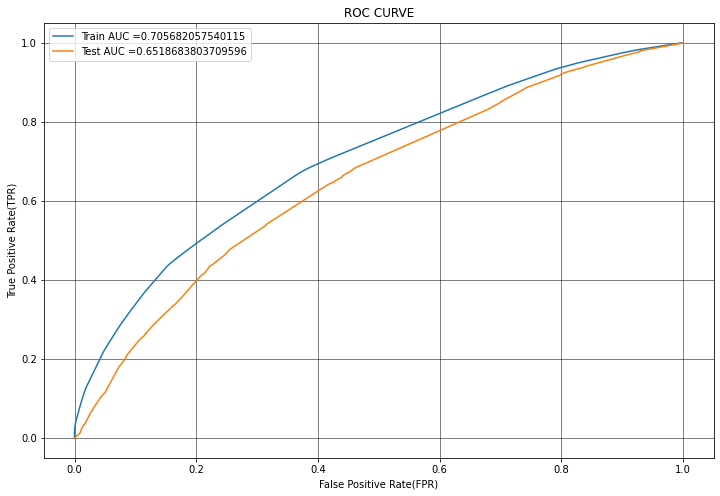

In [ ]:
model_set1=DecisionTreeClassifier(class_weight='balanced',max_depth = clf.best_params_["max_depth"],min_samples_split
= clf.best_params_["min_samples_split"])
model_set1.fit(X_tr_set_one,y_train)
y_train_probs = clf.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_set_one )[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

Confusion Matrix


In [ ]:
def find_best_threshold(threshould, fpr, tpr):
 t = threshould[np.argmax(tpr*(1-fpr))]
 # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
 print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
 return t
def predict_with_best_t(proba, threshould):
 predictions = []
 for i in proba:
     if i>=threshould:
        predictions.append(1)
     else:
        predictions.append(0)
 return predictions

Train Data

the maximum value of tpr*(1-fpr) 0.42302683283918663 for threshold 0.509
CONFUSION MATRIX OF TRAIN DATA


[[ 7106  3977]
 [21132 40981]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

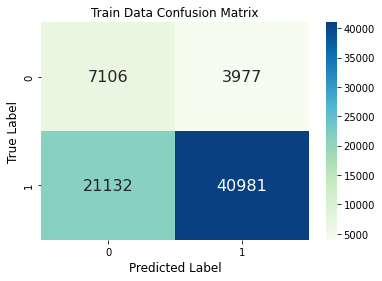

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t)) 
print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

Test Data

the maximum value of tpr*(1-fpr) 0.3741293480980552 for threshold 0.509
CONFUSION MATRIX OF TEST DATA


[[ 3183  2276]
 [10963 19630]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

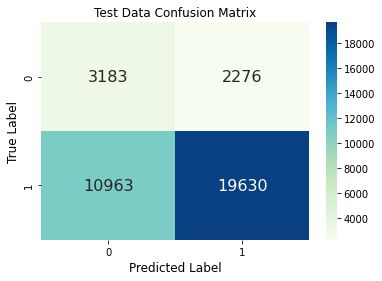

In [ ]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

Getting All the False Positive Data Points

In [ ]:
predict=predict_with_best_t(y_test_probs,best_t)

In [ ]:
fpi = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predict[i] == 1):
        fpi.append(i) # GETTING THE ALL FALSE POSITIVE INDICES
len(fpi)

2276

In [ ]:
import pandas as pd
cols = X_test.columns
X_test_false_Positive = pd.DataFrame(columns=cols) # MAKING THE FALSE POSITIVE DATAFRAME
X_test_false_Positive=X_test.iloc[fpi]
print(X_test_false_Positive.shape) 

(2276, 12)


In [ ]:
X_test_false_Positive.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
69487,sc,mrs,grades_3_5,10,literacy_language math_science,literacy mathematics,many students english language learners hard w...,228.89,0.039,0.242,0.719,0.9794


Wordcloud Of Essay Text For False Positive Dataset

In [ ]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_test_false_Positive['essay']:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
    val = str(word) 
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

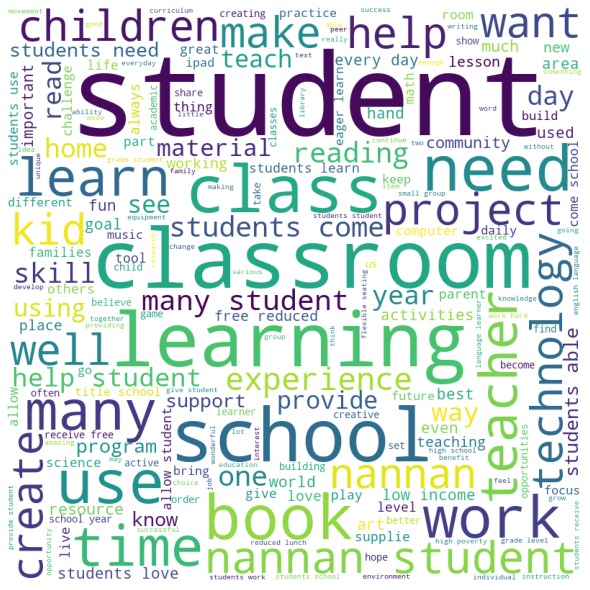

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Box Plot With The Price Of These False Positive Data Points

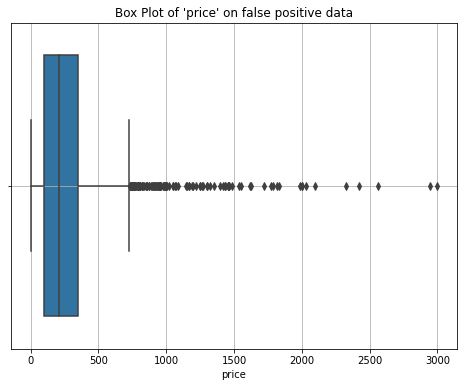

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot('price',data=X_test_false_Positive,orient="v").set_title("Box Plot of 'price' on false positive data")
plt.grid()

PDF Plot With The teacher_number_of_previously_posted_projects Of These False Positive Data Points

[8.73462214e-01 7.24956063e-02 2.68014060e-02 1.09841828e-02
 8.34797891e-03 1.75746924e-03 3.07557118e-03 1.75746924e-03
 4.39367311e-04 8.78734622e-04]
[  0.   24.8  49.6  74.4  99.2 124.  148.8 173.6 198.4 223.2 248. ]


Text(0.5, 0, 'teacher_number_of_previously_posted_projects')

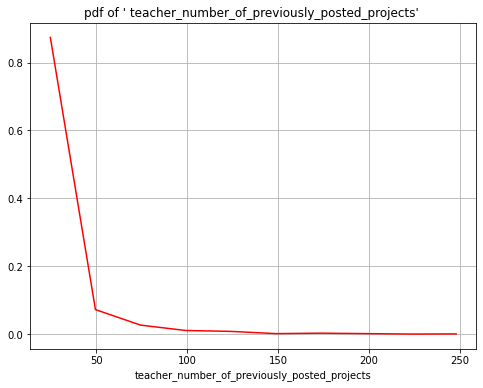

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
counts, bin_edges = np.histogram(X_test_false_Positive['teacher_number_of_previously_posted_projects'], bins=10,
 density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)
plt.plot(bin_edges[1:],pdf,color="red")
plt.title("pdf of ' teacher_number_of_previously_posted_projects' ")
plt.xlabel('teacher_number_of_previously_posted_projects')

Decision Tree using GridSearch CV (SET - 2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree_parameters = {'max_depth': [1, 5, 10, 50],
 'min_samples_split': [5, 10, 100, 500]}
decision_tree= DecisionTreeClassifier(class_weight='balanced')
clf = GridSearchCV(decision_tree, tree_parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_set_two,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

In [ ]:
for i in tqdm(X_test[ ]):
    print('Best score: ',clf.best_score_)
    print('Best Hyper parameters: ',clf.best_params_)

Plotting Hyperparameter v/s Auc

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

In [ ]:
from itertools import repeat
max_depth = [1, 5, 10, 50]
min_samples_split = [5, 10, 100, 500]
x1= max_depth
y1= min_samples_split
z1= train_auc
z2= cv_auc

In [ ]:
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name="train_auc")
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name="cv_auc")
data = [trace1, trace2]
layout = go.Layout(scene = dict(
 xaxis = dict(title='max_depth'),
 yaxis = dict(title='min_samples_split'),
 zaxis = dict(title='AUC SCORE'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Roc Plot Of Train And Test Data

In [ ]:
model_set1=DecisionTreeClassifier(class_weight='balanced',max_depth = clf.best_params_["max_depth"],min_samples_split
= clf.best_params_["min_samples_split"])
model_set1.fit(X_tr_set_two,y_train)
y_train_probs = clf.predict_proba(X_tr_set_two)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_set_two )[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

Confusion Matrix

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t
    
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
           predictions.append(1)
        else:
           predictions.append(0)
    return predictions

Train Data

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t)) 
print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

Test Data

In [ ]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

Getting All the False Positive Data Points

In [ ]:
predict=predict_with_best_t(y_test_probs,best_t)

In [ ]:
fpi = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predict[i] == 1): #GETTING THE FALSE POSITIVE INDICES
       fpi.append(i)
len(fpi)

In [ ]:
import pandas as pd
cols = X_test.columns
X_test_false_Positive = pd.DataFrame(columns=cols) # MAKING THE FALSE POSITIVE DATAFRAME
X_test_false_Positive=X_test.iloc[fpi]
print(X_test_false_Positive.shape) 

In [ ]:
X_test_false_Positive.head(1)

Wordcloud Of Essay Text For False Positive Dataset

In [ ]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_test_false_Positive['essay']:
    val = str(word) #https://www.geeksforgeeks.org/generating-word-cloud-python/
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot('price',data=X_test_false_Positive,orient="v").set_title("Box Plot of 'price' on false positive data")
plt.grid()

PDF Plot With The teacher_number_of_previously_posted_projects Of These False Positive Data Points

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
counts, bin_edges = np.histogram(X_test_false_Positive['teacher_number_of_previously_posted_projects'], bins=10,
 density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)
plt.plot(bin_edges[1:],pdf,color="red")
plt.title("pdf of ' teacher_number_of_previously_posted_projects' ")
plt.xlabel('teacher_number_of_previously_posted_projects')

# <font color='red'> <b>Task - 2</b></font>

In [ ]:
# 1. write your code in following steps for task 2
# 2. select all non zero features
# 3. Update your dataset i.e. X_train,X_test and X_cv so that it contains all rows and only non zero features
# 4. perform hyperparameter tuning and plot either heatmap or 3d plot.
# 5. Fit the best model. Plot ROC AUC curve and confusion matrix similar to model 1.


Selecting All The Features Which Are Having Non-Zero Feature Importance(Set -1)

In [ ]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_essay_tfidf, X_train_state_vec, X_train_teacher_vec, 
                       X_train_grade_vec, X_train_price_norm,X_train_category_vec,
                       X_train_subcategory_vec,X_train_submission_norm,X_train_neg_norm ,
                       X_train_pos_norm,X_train_neu_norm,X_train_compound_norm )).tocsr()

X_te_set_one = hstack((X_test_essay_tfidf, X_test_state_vec, X_test_teacher_vec, X_test_grade_vec, 
                       X_test_price_norm,X_test_category_vec,X_test_subcategory_vec,X_test_submission_norm,
                       X_test_neg_norm.shape,X_test_pos_norm.shape,X_test_neu_norm.shape,X_test_compound_norm.shape)).tocsr()

In [ ]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one .shape)

In [ ]:
clf_fea.fit(X_tr_set_one,y_train)

In [ ]:
features = clf_fea.feature_importances_
len(features)

In [ ]:
non_zero_features=[]
for i in range(len(features)):
 if features[i]>0: # FILTERING THE NON ZERO FEATURE IMPORTANT FEATURE INDICES
 non_zero_features.append(i)

In [ ]:
 print("NUMBER OF NON ZERO IMPORTANT FEATURES =" ,len(non_zero_features))

In [ ]:
X_tr_fea=X_tr_set_one[:,non_zero_features]
X_te_fea=X_te_set_one[:,non_zero_features] # CREATING NON ZERO FEATURE IMPORTANT DATASET

In [ ]:
print("SHAPE OF TRAIN AND TEST OF NON ZERO IMPORTANT FEATURES")
print(X_tr_fea.shape)
print(X_te_fea .shape)

In [ ]:
tree_parameters = {'max_depth': [1, 5, 10, 50],
 'min_samples_split': [5, 10, 100, 500]}
decision_tree= DecisionTreeClassifier(class_weight='balanced')
clf = GridSearchCV(decision_tree, tree_parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(X_tr_fea,y_train)

In [ ]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']

In [ ]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Plotting Hyperparameter v/s Auc

In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

In [ ]:
: from itertools import repeat
max_depth = [1, 5, 10, 50]
min_samples_split = [5, 10, 100, 500]
x1= max_depth
y1= min_samples_split
z1= train_auc
z2= cv_auc

In [ ]:
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name="train_auc")
trace2 = go.Scatter3d(x=x1,y=y1,z=z2, name="cv_auc")
data = [trace1, trace2]
layout = go.Layout(scene = dict(
 xaxis = dict(title='max_depth'),
 yaxis = dict(title='min_samples_split'),
 zaxis = dict(title='AUC SCORE'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Roc Plot Of Train And Test Data

In [ ]:
model_set1=DecisionTreeClassifier(class_weight='balanced',max_depth = clf.best_params_["max_depth"],min_samples_split
= clf.best_params_["min_samples_split"])
model_set1.fit(X_tr_fea,y_train)
y_train_probs = clf.predict_proba(X_tr_fea)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_fea )[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

Confusion Matrix

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
           predictions.append(1)
        else:
           predictions.append(0)
    return predictions

Train Data

In [ ]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t)) # https://stackoverflow.com/question
s/35572000/how-can-i-plot-a-confusion-matrix
print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

Test Data

In [ ]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

Getting All the False Positive Data Points

In [ ]:
predict=predict_with_best_t(y_test_probs,best_t)

In [ ]:
fpi = []
for i in range(len(y_test)):
    if(y_test[i]==0) & (predict[i] == 1):
       fpi.append(i)
len(fpi)

In [ ]:
import pandas as pd
cols = X_test.columns
X_test_false_Positive = pd.DataFrame(columns=cols) # MAKING THE FALSE POSITIVE DATAFRAME
X_test_false_Positive=X_test.iloc[fpi]
print(X_test_false_Positive.shape)

wordcloud Of Essay Text For False Positive Dataset

In [ ]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS)
for word in X_test_false_Positive['essay']:
    val = str(word) #https://www.geeksforgeeks.org/generating-word-cloud-python/
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Box Plot With The Price Of These False Positive Data Points

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot('price',data=X_test_false_Positive,orient="v").set_title("Box Plot of 'price' on false positive data")
plt.grid()

Pdf Plot With The teacher_number_of_previously_posted_projects Of These False Positive Data Points

In [ ]:
plt.figure(figsize=(8,6))
plt.grid()
counts, bin_edges = np.histogram(X_test_false_Positive['teacher_number_of_previously_posted_projects'], bins=10,
 density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)
plt.plot(bin_edges[1:],pdf,color="red")
plt.title("pdf of ' teacher_number_of_previously_posted_projects' ")
plt.xlabel('teacher_number_of_previously_posted_projects')

Summary

In [ ]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row([1,"TFIDF", "DECSION TREE", "max_depth =10 , min_samples_split=500", 0.65042])
table.add_row([2,"TFIDF W2V", "DECSION TREE"," max_depth =5 , min_samples_split=500", 0.56212])
table.add_row([3,"TFIDF NON ZERO FEATURE IMPORTANCE", "DECSION TREE", "max_depth =10 , min_samples_split=500", 0.650380])
print(table)

In [ ]:
clf_fea= DecisionTreeClassifier(class_weight='balanced',max_depth=None,min_samples_split=500)

In [ ]:
# Tabulate your results